## Proyecto de Análisis de Datos.

### Introducción al proyecto.

El objetivo de este proyecto es identificar estrategias para aumentar los ingresos de una tienda online mediante dos enfoques complementarios: la priorización de hipótesis y el análisis de una prueba A/B.

En la **Parte 1**, se trabaja con el archivo hypotheses_us.csv, que contiene nueve hipótesis sobre posibles mejoras. Cada hipótesis incluye estimaciones de Reach (alcance), Impact (impacto), Confidence (confianza) y Effort (esfuerzo). Para priorizarlas, se aplican dos frameworks ampliamente utilizados en la toma de decisiones:

* **ICE** (Impact, Confidence, Effort): ayuda a identificar iniciativas de alto impacto y alta probabilidad de éxito en relación con el esfuerzo requerido.

* **RICE** (Reach, Impact, Confidence, Effort): incorpora además el alcance, permitiendo valorar qué tantas personas se verían beneficiadas por cada hipótesis.

Se ordenan las hipótesis según ambos métodos y se comparan los resultados, analizando cómo la introducción del alcance (RICE) modifica la priorización respecto al enfoque ICE.

En la **Parte 2**, se analiza un experimento A/B con datos de los archivos orders_us.csv y visits_us.csv. El propósito es evaluar si una nueva versión del sitio (grupo B) supera a la actual (grupo A). Para ello se realizan:

* Visualizaciones de ingresos, tamaño de pedido promedio y tasas de conversión.

* Identificación y tratamiento de anomalías mediante percentiles.

* Pruebas de significancia estadística para evaluar las diferencias entre grupos, tanto en datos brutos como filtrados.

El análisis permite extraer conclusiones sobre el desempeño de cada grupo y tomar una decisión fundamentada sobre el futuro de la nueva versión del sitio.

## Parte 1. Priorizar hipótesis:

In [54]:
# Importamos librerías
import pandas as pd

# Leemos el archivo
file_path = '/datasets/hypotheses_us.csv'

df = pd.read_csv(file_path, sep=';')

# Limpieza de nombres de columnas
df.columns = df.columns.str.strip()        # quita espacios adelante/atrás
df.columns = df.columns.str.replace('\ufeff','', regex=True)  # quita caracteres ocultos (BOM)
df.columns = df.columns.str.lower()  

print(df.columns.tolist())  # para verificar

['hypothesis', 'reach', 'impact', 'confidence', 'effort']


In [55]:

# Calculamos ICE y RICE
df['ice'] = (df['impact'] * df['confidence']) / df['effort']
df['rice'] = (df['reach'] * df['impact'] * df['confidence']) / df['effort']

# Ordenamos
ice_sorted = df.sort_values(by='ice', ascending=False).reset_index(drop=True)
rice_sorted = df.sort_values(by='rice', ascending=False).reset_index(drop=True)

#Framework ICE

print("Top hypotheses by ICE:")
print(ice_sorted[['hypothesis','reach','impact','confidence','effort','ice']])




Top hypotheses by ICE:
                                          hypothesis  reach  impact  \
0  Launch a promotion that gives users discounts ...      1       9   
1  Add two new channels for attracting traffic. T...      3      10   
2  Add a subscription form to all the main pages....     10       7   
3  Show banners with current offers and sales on ...      5       3   
4  Add product recommendation blocks to the store...      8       3   
5  Launch your own delivery service. This will sh...      2       5   
6  Add a customer review page. This will increase...      3       2   
7  Change the category structure. This will incre...      8       3   
8  Change the background color on the main page. ...      3       1   

   confidence  effort        ice  
0           9       5  16.200000  
1           8       6  13.333333  
2           8       5  11.200000  
3           8       3   8.000000  
4           7       3   7.000000  
5           4      10   2.000000  
6           2       3

In [56]:
# Framework RICE


print("\nTop hypotheses by RICE:")
print(rice_sorted[['hypothesis','reach','impact','confidence','effort','rice']])



Top hypotheses by RICE:
                                          hypothesis  reach  impact  \
0  Add a subscription form to all the main pages....     10       7   
1  Add product recommendation blocks to the store...      8       3   
2  Add two new channels for attracting traffic. T...      3      10   
3  Show banners with current offers and sales on ...      5       3   
4  Launch a promotion that gives users discounts ...      1       9   
5  Change the category structure. This will incre...      8       3   
6  Launch your own delivery service. This will sh...      2       5   
7  Add a customer review page. This will increase...      3       2   
8  Change the background color on the main page. ...      3       1   

   confidence  effort   rice  
0           8       5  112.0  
1           7       3   56.0  
2           8       6   40.0  
3           8       3   40.0  
4           9       5   16.2  
5           3       8    9.0  
6           4      10    4.0  
7           2   

In [57]:
# Añadir posiciones en cada ranking
ice_sorted['ICE_rank'] = ice_sorted.index + 1
rice_sorted['RICE_rank'] = rice_sorted.index + 1

# Unir por hipótesis
comparison = ice_sorted[['hypothesis','ICE_rank']].merge(
    rice_sorted[['hypothesis','RICE_rank']], 
    on='hypothesis'
)

# Calcular cambio de posición
comparison['Change'] = comparison['ICE_rank'] - comparison['RICE_rank']

print(comparison.sort_values(by='Change', ascending=False))

                                          hypothesis  ICE_rank  RICE_rank  \
4  Add product recommendation blocks to the store...         5          2   
2  Add a subscription form to all the main pages....         3          1   
7  Change the category structure. This will incre...         8          6   
3  Show banners with current offers and sales on ...         4          4   
8  Change the background color on the main page. ...         9          9   
1  Add two new channels for attracting traffic. T...         2          3   
5  Launch your own delivery service. This will sh...         6          7   
6  Add a customer review page. This will increase...         7          8   
0  Launch a promotion that gives users discounts ...         1          5   

   Change  
4       3  
2       2  
7       2  
3       0  
8       0  
1      -1  
5      -1  
6      -1  
0      -4  


### Conclusiones de los hallazgos:

1. **El uso de RICE cambia significativamente la priorización frente a ICE.**

* Con ICE, la mejor idea parecía ser “Launch a promotion that gives users discounts…” porque su impacto y confianza eran altos.

* Con RICE, la hipótesis líder pasa a ser “Add a subscription form to all the main pages”, debido a que combina buen impacto y confianza con un alcance mucho mayor (reach = 10).

2. **Las hipótesis con mayor alcance suben posiciones.**

* “Add product recommendation blocks” (Reach = 8) subió del puesto 5 → 2.

* “Add a subscription form…” (Reach = 10) subió del 3 → 1.

* “Change the category structure” (Reach = 8) también mejoró del 8 → 6.

Esto confirma que RICE da más peso a iniciativas que afectan a más usuarios.

3. **Las hipótesis con bajo alcance pierden relevancia.**

* “Launch a promotion that gives users discounts…” cayó del 1 → 5 (cambio -4). Su alcance era solo 1, por lo que, aunque tenía gran impacto, beneficia a muy pocos usuarios.

* También se ven descensos moderados en “Launch your own delivery service” (6 → 7) y “Add a customer review page” (7 → 8).

4. **Algunas hipótesis mantienen la misma posición.**

* “Show banners with current offers…” quedó en 4 → 4, sin cambios, mostrando que su balance de impacto, confianza y alcance es estable.

* “Change background color…” sigue última (9 → 9), confirmando que es una hipótesis de bajo valor sin importar la métrica usada.

### Conclusión final:

* **ICE** favorece ideas con alto impacto y confianza aunque lleguen a pocos usuarios.

* **RICE** redistribuye prioridades, destacando aquellas hipótesis que tienen mayor alcance y, por lo tanto, potencial de generar más valor en el negocio.

En este caso, el uso de RICE pone en primer lugar las hipótesis más escalables (formulario de suscripción y recomendaciones de productos), mientras que reduce la importancia de acciones más limitadas en alcance como descuentos o cambios de diseño.

## Parte 2. Análisis del test A/B

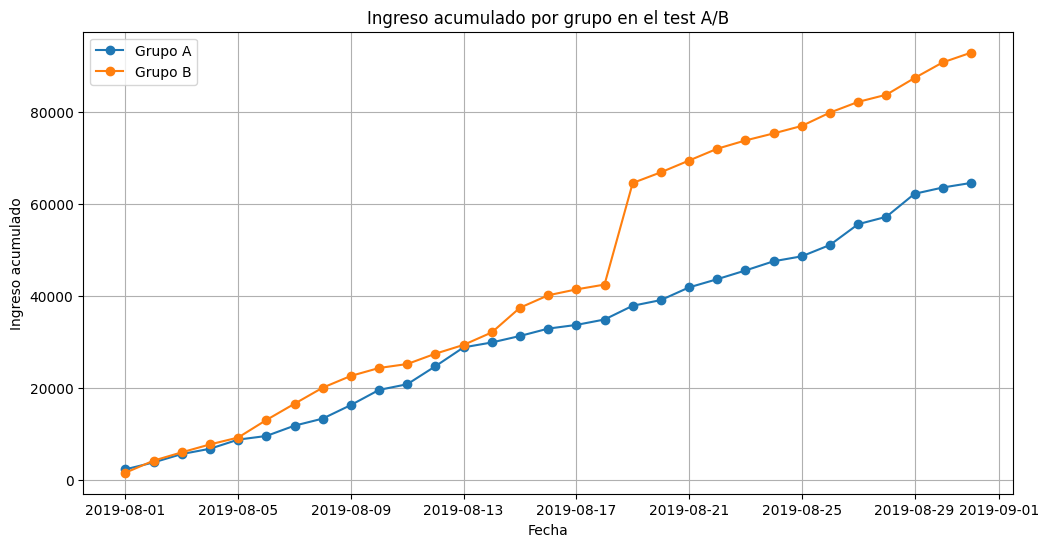

In [58]:
# 1. Representamos gráficamente el ingreso acumulado por grupo:

# Importar librerías
import matplotlib.pyplot as plt

# Cargar los datos
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

# Asegurarnos de que las fechas son tipo datetime
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

# Agrupar ingresos acumulados por grupo y fecha
revenue_group = (
    orders
    .groupby(['date', 'group'])
    .agg({'revenue':'sum'})
    .reset_index()
)

# Calcular ingreso acumulado
revenue_group['cumulative_revenue'] = (
    revenue_group
    .groupby('group')['revenue']
    .cumsum()
)

# Pivotear para graficar más fácil
pivot_revenue = revenue_group.pivot(index='date', columns='group', values='cumulative_revenue')

# Graficar
plt.figure(figsize=(12,6))
plt.plot(pivot_revenue.index, pivot_revenue['A'], label='Grupo A', marker='o')
plt.plot(pivot_revenue.index, pivot_revenue['B'], label='Grupo B', marker='o')

plt.title('Ingreso acumulado por grupo en el test A/B')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.grid(True)
plt.show()

### Conclusiones y conjeturas sobre el ingreso acumulado por grupo

1. Tendencia general:

* Ambos grupos muestran un crecimiento constante en ingresos acumulados a lo largo del tiempo.

* Sin embargo, el grupo B supera claramente al grupo A en la mayor parte del período de prueba.

2. Momento de divergencia:

* Hasta el 15 de agosto, los grupos A y B crecen de forma relativamente paralela, con B apenas un poco por encima.

* A partir del 18 de agosto, se observa un salto abrupto en el grupo B, que marca una diferencia significativa y sostenida en el ingreso acumulado frente al grupo A.

3. Diferencia final:

* Al finalizar el período, grupo B acumula cerca de 90,000 unidades monetarias, mientras que grupo A llega apenas a unos 65,000.

* Esto significa que el grupo B logró aproximadamente un 30-40% más de ingresos acumulados en el mismo tiempo.

4. Posible explicación del salto en B:

* Puede deberse a usuarios con pedidos atípicamente altos (outliers) que inflaron los ingresos.

* Otra posibilidad es que la nueva versión del sitio (grupo B) realmente haya motivado más compras grandes.

5. **Conjetura principal:**

* Si bien el grupo B parece más rentable, el salto tan pronunciado sugiere la necesidad de un análisis adicional  antes de concluir que la nueva versión es claramente superior.

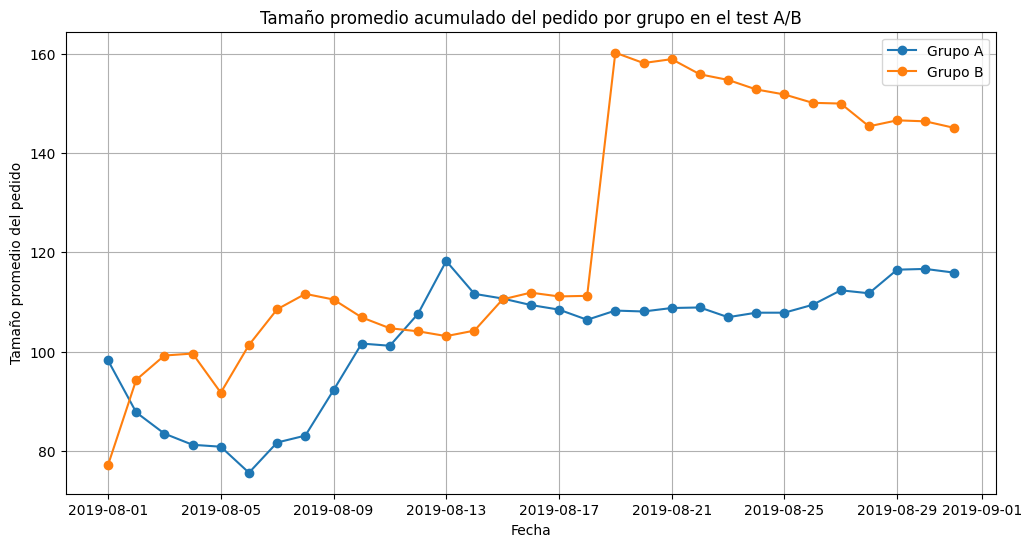

In [59]:
#2.  Representamos gráficamente el tamaño de pedido promedio acumulado por grupo:

# Agrupar ingresos y pedidos por fecha y grupo
orders_group = (
    orders
    .groupby(['date', 'group'])
    .agg({'revenue': 'sum', 'transactionId': 'nunique'})
    .reset_index()
)

# Calcular acumulados
orders_group['cumulative_revenue'] = (
    orders_group.groupby('group')['revenue'].cumsum()
)
orders_group['cumulative_orders'] = (
    orders_group.groupby('group')['transactionId'].cumsum()
)

# Calcular tamaño promedio acumulado del pedido
orders_group['cumulative_avg_order'] = (
    orders_group['cumulative_revenue'] / orders_group['cumulative_orders']
)

# Pivotear para graficar más fácil
pivot_avg = orders_group.pivot(index='date', columns='group', values='cumulative_avg_order')

# Graficar
plt.figure(figsize=(12,6))
plt.plot(pivot_avg.index, pivot_avg['A'], label='Grupo A', marker='o')
plt.plot(pivot_avg.index, pivot_avg['B'], label='Grupo B', marker='o')

plt.title('Tamaño promedio acumulado del pedido por grupo en el test A/B')
plt.xlabel('Fecha')
plt.ylabel('Tamaño promedio del pedido')
plt.legend()
plt.grid(True)
plt.show()

### Conclusiones y conjeturas sobre el tamaño de pedido promedio acumulado por grupo:

1. Inicio similar con fluctuaciones:

Durante los primeros días, ambos grupos presentan valores relativamente cercanos, aunque con oscilaciones normales por el bajo volumen de pedidos acumulados.

2. Grupo B crece a mediados de agosto:

A partir del 18 de agosto, el tamaño promedio del pedido en el grupo B muestra un salto muy fuerte, alcanzando niveles cercanos a 160 unidades monetarias, mientras que el grupo A se mantiene estable alrededor de 110.

Esto sugiere la aparición de pedidos atípicamente altos (outliers) en el grupo B.

3. Grupo A es más estable:
 
Después de las primeras fluctuaciones, el tamaño promedio en el grupo A converge y se mantiene en torno a los 110–115, lo que refleja un comportamiento más consistente.

4. Diferencia clara entre grupos:

Al final del periodo, el grupo B mantiene un tamaño de pedido promedio significativamente mayor que el grupo A (≈145 vs. 115).

5. **Conjetura principal:**

* El incremento abrupto en el grupo B probablemente se debe a pedidos atípicos de gran valor, más que a un cambio real en el comportamiento general de los usuarios.

* El grupo A podría reflejar mejor el comportamiento típico de los clientes, mientras que el grupo B muestra un sesgo causado por esos valores extremos.

* Este hallazgo anticipa la necesidad de filtrar anomalías antes de hacer comparaciones estadísticas confiables.

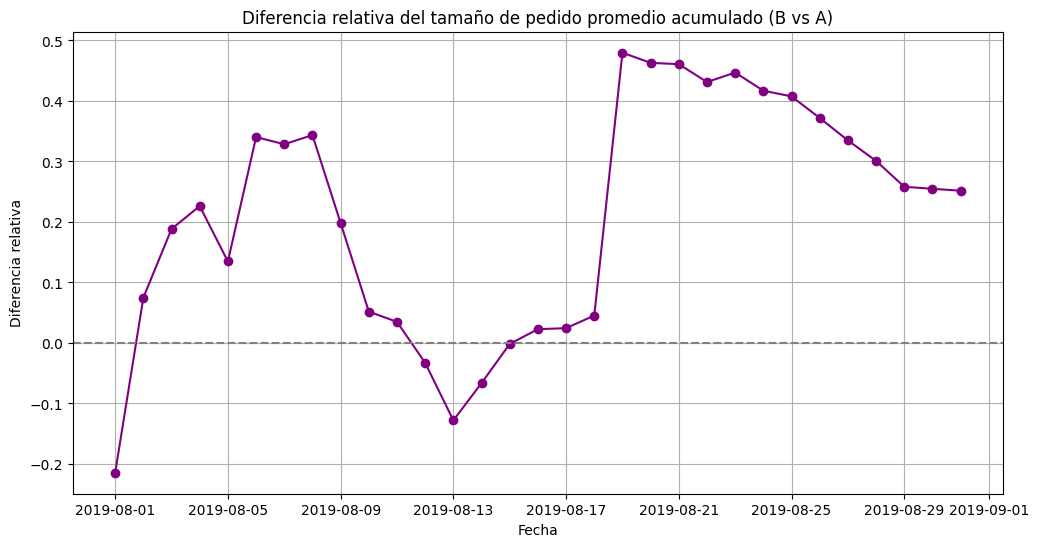

In [60]:
# 3. Representamos gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.

# Crear dataframe comparando tamaños promedio acumulados
relative_diff = (
    pivot_avg['B'] / pivot_avg['A'] - 1
)

# Graficar
plt.figure(figsize=(12,6))
plt.plot(relative_diff.index, relative_diff, marker='o', color='purple')

plt.axhline(y=0, color='gray', linestyle='--')  # Línea de referencia
plt.title('Diferencia relativa del tamaño de pedido promedio acumulado (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.grid(True)
plt.show()




### Conclusiones y conjeturas sobre el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A:

1. Inestabilidad inicial (1–10 de agosto):

* La diferencia relativa fluctúa bastante, incluso llegando a valores negativos (grupo B con pedidos promedio más pequeños que A).

* Esto es normal al inicio de un test A/B porque el número de pedidos aún es bajo y los datos son muy sensibles a variaciones pequeñas.

2. Estabilización y salto brusco (después del 18 de agosto):

* Se observa un salto muy marcado alrededor del 18 de agosto, donde la diferencia relativa sube casi al +50%.

* Esto sugiere la presencia de outliers o pedidos excepcionalmente grandes en el grupo B, que inflaron el tamaño promedio.

3. Tendencia posterior:

* Después del salto, la diferencia se mantiene positiva y estable, entre +25% y +45%, lo que indica que el grupo B en promedio tuvo pedidos más grandes que el grupo A en la mayoría del período.

* Aun así, la curva muestra una ligera tendencia descendente al final de agosto, lo que podría significar que el efecto se está reduciendo.

4. **Conjeturas principales:**

* El grupo B parece tener una ventaja clara en el tamaño promedio de pedido, pero esta diferencia depende mucho de algunos valores atípicos.

* Es probable que un pequeño número de clientes en B haya hecho pedidos inusualmente grandes, distorsionando los resultados.

* Para confirmar si la diferencia es real y no solo producto de outliers, sería necesario:

--Revisar los pedidos extremos.

--Repetir el análisis con datos sin outliers y comparar.

--Ver si la diferencia se mantiene en métricas más robustas (ej. mediana en lugar de promedio).

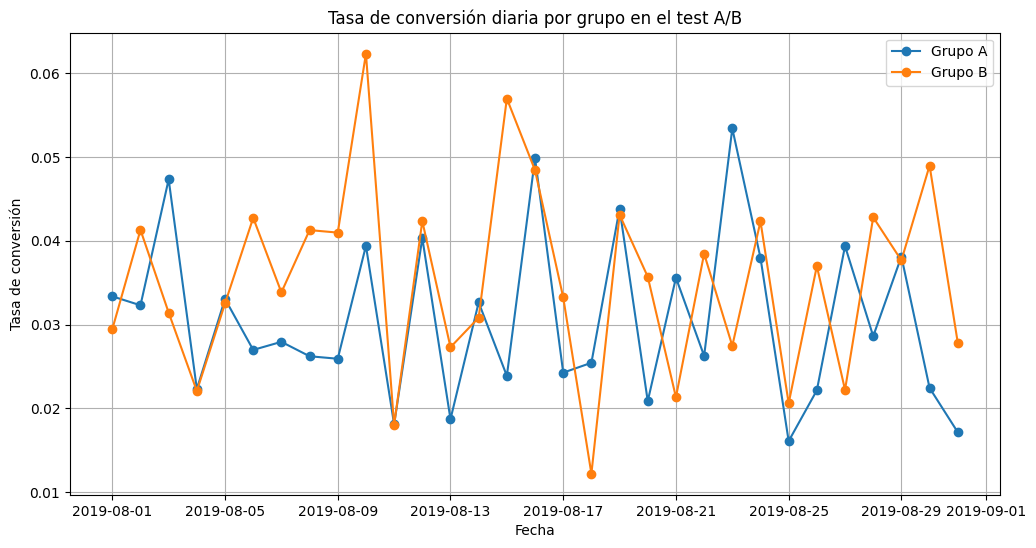

In [61]:
# 4. Calculamos la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día:


# Agrupar pedidos diarios por grupo
orders_daily = (
    orders.groupby(['date', 'group'])
    .agg({'transactionId':'nunique'})
    .reset_index()
    .rename(columns={'transactionId':'orders'})
)

# Agrupar visitas diarias por grupo
visits_daily = visits.groupby(['date', 'group'])['visits'].sum().reset_index()

# Unir pedidos y visitas
conversion = pd.merge(orders_daily, visits_daily, on=['date','group'])
conversion['conversion'] = conversion['orders'] / conversion['visits']

# Pivotear para graficar
pivot_conversion = conversion.pivot(index='date', columns='group', values='conversion')

# Gráfica
plt.figure(figsize=(12,6))
plt.plot(pivot_conversion.index, pivot_conversion['A'], label='Grupo A', marker='o')
plt.plot(pivot_conversion.index, pivot_conversion['B'], label='Grupo B', marker='o')

plt.title('Tasa de conversión diaria por grupo en el test A/B')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.legend()
plt.grid(True)
plt.show()

### Conclusiones y conjeturas sobre la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día:

1. Alta volatilidad en ambos grupos

* La tasa de conversión fluctúa bastante día a día en los dos grupos.

* Esto es normal en un A/B test cuando se observa a nivel diario, porque el número de visitas y pedidos por día no es tan grande.

2. Grupo B muestra picos más altos

* En varias fechas (por ejemplo, alrededor del 9 y 15 de agosto) el grupo B supera el 0.05–0.06, mientras que A rara vez alcanza esos niveles.

* Esto sugiere que B tuvo días con un rendimiento claramente mejor.

3. Grupo A es más estable, pero más bajo en general

* Aunque el grupo A presenta menos picos extremos, la mayoría de sus valores se mantienen entre 0.02 y 0.04, ligeramente por debajo del grupo B en varias ocasiones.

4. Cruces entre los grupos

* Hay días donde el grupo A supera a B (ej. 4, 12, 21 y 23 de agosto).

* Sin embargo, esas diferencias no parecen sostenerse, mientras que B logra mantener un desempeño superior en varios momentos clave.

5. **Conjeturas principales:**

* Es probable que Grupo B tenga una conversión acumulada mayor que A si se suman los resultados de todo el periodo (aunque necesitamos confirmarlo con el gráfico acumulado o pruebas estadísticas).

* Las fluctuaciones indican que puede haber anomalías (ej. usuarios con compras inusualmente grandes o bajas visitas en ciertos días que distorsionan el ratio).

* A nivel de tendencia, el grupo B apunta a ser más prometedor en términos de conversión, pero la variabilidad diaria sugiere que no se debe tomar una decisión solo con esta vista puntual.

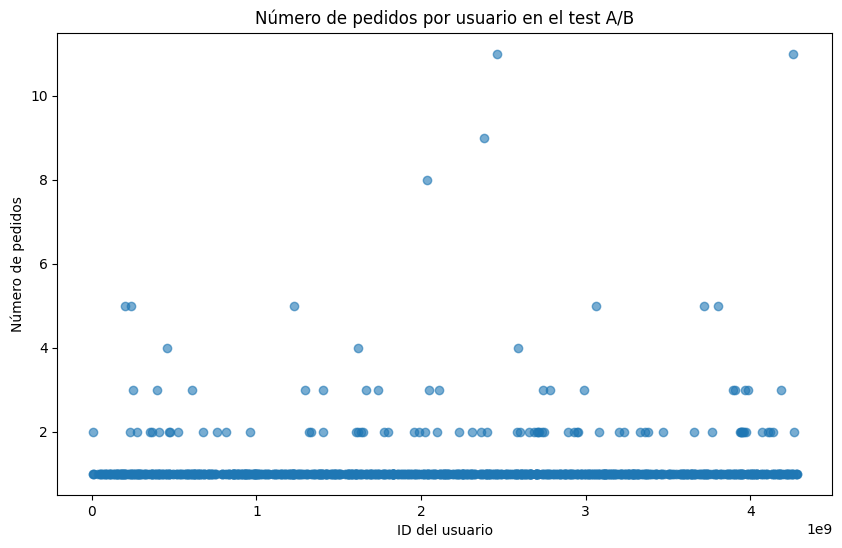

In [62]:
# 5. Trazamos un gráfico de dispersión del número de pedidos por usuario:

# Cargar datos
orders = pd.read_csv('/datasets/orders_us.csv')

# Contar número de pedidos por usuario
orders_by_user = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})

# Renombrar la columna
orders_by_user.columns = ['user_id', 'orders']

# Gráfico de dispersión
plt.figure(figsize=(10,6))
plt.scatter(orders_by_user['user_id'], orders_by_user['orders'], alpha=0.6)
plt.title('Número de pedidos por usuario en el test A/B')
plt.xlabel('ID del usuario')
plt.ylabel('Número de pedidos')
plt.show()

### Conclusiones y conjeturas sobre el gráfico de dispersión del número de pedidos por usuario:

1. La mayoría de los usuarios realizaron solo 1 pedido

* Esto se observa en la concentración de puntos en la línea horizontal de y = 1, lo cual es lo esperado en un e-commerce.

2. Existen usuarios con múltiples pedidos

* Varios usuarios hicieron 2 a 5 pedidos.

* También aparecen casos extremos con hasta 8, 10 e incluso 11 pedidos.

3. Presencia clara de outliers

* Los usuarios con más de 3–4 pedidos se desvían del comportamiento típico.

* Estos valores extremos pueden distorsionar métricas como el promedio de conversión o el tamaño promedio de pedido.

4. **Conjeturas principales:**

* Estos usuarios “súper activos” podrían corresponder a clientes muy fieles o incluso a comportamientos atípicos (ej. pruebas internas, bots, o grandes compradores corporativos).

* Para un análisis estadístico justo, convendría filtrar outliers (por ejemplo, excluir usuarios con más de 2 pedidos, o usar los percentiles 95 y 99 como umbral).

* La distribución refuerza la necesidad de calcular métricas con datos filtrados, ya que los resultados del test A/B podrían estar sesgados por unos pocos usuarios muy activos.

In [63]:
# 6. Calculamos los percentiles 95 y 99 del número de pedidos por usuario:
#Definimos el punto en el cual un punto de datos se convierte en una anomalía:

# Importar librerías
import numpy as np

# Agrupar por usuario y contar pedidos
orders_by_user = orders.groupby('visitorId').agg({'transactionId':'nunique'}).reset_index()
orders_by_user.columns = ['user_id', 'orders']

# Calcular percentiles 95 y 99
percentiles = np.percentile(orders_by_user['orders'], [95, 99])
p95, p99 = percentiles

print("Percentil 95:", p95)
print("Percentil 99:", p99)

# Definir anomalías
anomaly_threshold_95 = orders_by_user[orders_by_user['orders'] > p95]
anomaly_threshold_99 = orders_by_user[orders_by_user['orders'] > p99]

print("\nUsuarios con más de", p95, "pedidos (posibles anomalías con 95%):")
print(anomaly_threshold_95)

print("\nUsuarios con más de", p99, "pedidos (anomalías con 99%):")
print(anomaly_threshold_99)

Percentil 95: 2.0
Percentil 99: 4.0

Usuarios con más de 2.0 pedidos (posibles anomalías con 95%):
         user_id  orders
44     199603092       5
55     237748145       5
59     249864742       3
97     393266494       3
114    457167155       4
148    611059232       3
299   1230306981       5
311   1294878855       3
340   1404934699       3
393   1614305549       4
406   1668030113       3
422   1738359350       3
487   2038680547       8
491   2044997962       3
504   2108163459       3
569   2378935119       9
591   2458001652      11
619   2587333274       4
667   2742574263       3
677   2780786433       3
726   2988190573       3
744   3062433592       5
897   3717692402       5
917   3803269165       5
932   3891541246       3
937   3908431265       3
959   3967698036       3
963   3984495233       3
1009  4186807279       3
1023  4256040402      11

Usuarios con más de 4.0 pedidos (anomalías con 99%):
         user_id  orders
44     199603092       5
55     237748145      

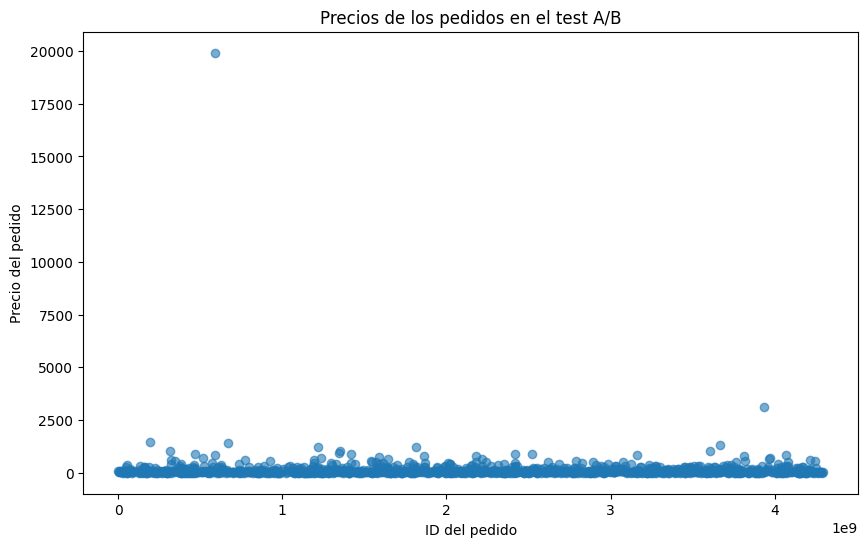

In [64]:
# 7. Gráfico de dispersión de precios de los pedidos: 
plt.figure(figsize=(10,6))
plt.scatter(orders['transactionId'], orders['revenue'], alpha=0.6)

plt.title("Precios de los pedidos en el test A/B")
plt.xlabel("ID del pedido")
plt.ylabel("Precio del pedido")
plt.show()

### Conclusiones y conjeturas sobre el gráfico de dispersión de los precios de los pedidos:

1. La mayoría de los pedidos tienen precios bajos

* La gran concentración de puntos se encuentra muy cerca del eje horizontal, con valores relativamente pequeños.

* Esto indica que los usuarios suelen hacer pedidos de bajo costo, probablemente dentro de un rango de precios bastante reducido.

2. Existen valores atípicos muy elevados (outliers)

* Hay algunos puntos dispersos con precios que superan los 2000, 5000 e incluso cerca de 20 000.

* Estos valores son anomalías claras que podrían deberse a:

--Errores de registro (ej. doble conteo, problemas en la carga de datos).

--Pedidos extraordinariamente grandes o inusuales.

3. Distribución muy sesgada

* La presencia de pocos pedidos con montos muy altos hace que la distribución sea asimétrica.

* Esto afecta métricas como la media, por lo que es preferible usar mediana o percentiles para describir el comportamiento típico.

4. Impacto en el test A/B

* Si no se eliminan o ajustan estos valores atípicos, podrían distorsionar los resultados del experimento, dando una falsa impresión de diferencias entre grupos.

* Una práctica común es usar los percentiles 95 o 99 para fijar un umbral y considerar los valores superiores como anomalías.

5. **Conjetura principal:**

El gráfico muestra que la mayoría de los pedidos tienen un precio bajo y relativamente homogéneo, pero existen pedidos extremadamente altos que se comportan como anomalías.

In [65]:
# 8. Calculamos los percentiles 95 y 99 de los precios de los pedidos:
# Defininimos el punto en el cual un punto de datos se convierte en una anomalía:

# Calcular percentiles 95 y 99 de los precios de los pedidos
percentil_95 = np.percentile(orders['revenue'], 95)
percentil_99 = np.percentile(orders['revenue'], 99)

print("Percentil 95:", percentil_95)
print("Percentil 99:", percentil_99)

# Definir umbral de anomalías
print(f"Un pedido se considera una posible anomalía si su precio es mayor a {percentil_95:.2f} (95%)")
print(f"Un pedido se considera una anomalía clara si su precio es mayor a {percentil_99:.2f} (99%)")


Percentil 95: 435.54
Percentil 99: 900.9039999999999
Un pedido se considera una posible anomalía si su precio es mayor a 435.54 (95%)
Un pedido se considera una anomalía clara si su precio es mayor a 900.90 (99%)


In [66]:
# 9. Encontramos la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto: 

from scipy import stats



# --- Paso 1: contar conversiones por usuario ---
# Un usuario convierte si tiene al menos un pedido
conversions = orders.groupby(['visitorId', 'group'])['transactionId'].count().reset_index()
conversions['converted'] = 1  # marca conversión

# --- Paso 2: calcular conversion rate por grupo ---
# Número de usuarios únicos en cada grupo (visitantes)
visits_group = visits.groupby('group')['visits'].sum()

# Número de usuarios con al menos un pedido por grupo
orders_group = conversions.groupby('group')['converted'].sum()

conversion_rate = orders_group / visits_group
print("Tasas de conversión por grupo:")
print(conversion_rate)

# --- Paso 3: prueba de significancia ---
# Crear arrays binarios: 1 = conversión, 0 = no conversión
results = []

for group in ['A','B']:
    n_visits = visits_group[group]
    n_orders = orders_group[group]
    conversions_array = np.array([1]*n_orders + [0]*(n_visits - n_orders))
    results.append(conversions_array)

# Mann-Whitney U test
stat, p_value = stats.mannwhitneyu(results[0], results[1], alternative="two-sided")

print("Estadístico U:", stat)
print("p-value:", p_value)

# --- Conclusión ---
alpha = 0.05
if p_value < alpha:
    print("La diferencia en la conversión entre los grupos ES estadísticamente significativa.")
else:
    print("No hay evidencia estadísticamente significativa de que la conversión difiera entre los grupos.")

Tasas de conversión por grupo:
group
A    0.026847
B    0.030979
dtype: float64
Estadístico U: 176472814.0
p-value: 0.016746169422850104
La diferencia en la conversión entre los grupos ES estadísticamente significativa.



### Conclusiones y conjeturas sobre la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto:

1. Tasa de conversión por grupo

* Grupo A: 2.68 %

* Grupo B: 3.10 %

El grupo B tiene una tasa de conversión ligeramente mayor que el grupo A.

2. Significancia estadística

* Prueba de Mann–Whitney U:

--Estadístico U = 176,472,814.0

--p-value ≈ 0.0167

* Como el p-value < 0.05, concluimos que la diferencia entre los grupos es estadísticamente significativa.

Es decir, la diferencia observada no se debe al azar con alta probabilidad.

4. **Conjeturas principales:**

* El cambio aplicado al grupo B probablemente mejora la conversión.

El experimento sugiere que la variante (grupo B) tiene un efecto positivo, aunque modesto.

* Magnitud del impacto.

La mejora es de aproximadamente 0.0041 puntos porcentuales (3.10% - 2.68%), lo que equivale a un incremento relativo de alrededor de 15% en la conversión.

* Posibles implicaciones de negocio.

--Si el aumento de conversión se mantiene a escala, el grupo B podría generar más ingresos en el tiempo.

--Sin embargo, antes de implementar el cambio globalmente, conviene analizar si el aumento en conversión compensa posibles costos o riesgos asociados con la variante.


In [67]:
# 10. Encontramos la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto:

# Dividir los ingresos por grupo
orders_A = orders[orders['group'] == 'A']['revenue']
orders_B = orders[orders['group'] == 'B']['revenue']

# Calcular medias
mean_A = orders_A.mean()
mean_B = orders_B.mean()

print(f"Tamaño promedio de pedido - Grupo A: {mean_A:.2f}")
print(f"Tamaño promedio de pedido - Grupo B: {mean_B:.2f}")

# --- Prueba estadística ---
# Usamos Mann-Whitney U porque los datos de ingresos suelen no ser normales
stat, p_value = stats.mannwhitneyu(orders_A, orders_B, alternative='two-sided')

print(f"Estadístico U: {stat}")
print(f"p-value: {p_value}")


Tamaño promedio de pedido - Grupo A: 115.90
Tamaño promedio de pedido - Grupo B: 145.06
Estadístico U: 175872.5
p-value: 0.6915246773264736



### Conclusiones y conjeturas sobre la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto:

1. Promedios observados

* Grupo A: $115.90

* Grupo B: $145.06

A simple vista, el grupo B parece tener pedidos de mayor valor promedio.

2. Prueba estadística (Mann–Whitney U)

* Estadístico U: 175,872.5

* p-value: 0.6915

El p-value es muy alto (> 0.05), lo que significa que no existe evidencia estadísticamente significativa para afirmar que los tamaños promedio de los pedidos difieran entre los grupos.

3. **Conjeturas principales:**

* La diferencia observada en los promedios podría deberse al azar y no a un efecto real de la variante B.

* Esto sugiere que, aunque el grupo B muestra pedidos más grandes en promedio, la variabilidad de los datos es muy amplia y la prueba no respalda una diferencia real.

* Es posible que existan outliers (pedidos inusualmente altos) que estén inflando la media en el grupo B, lo cual justifica la necesidad de analizar los datos filtrados (eliminando anomalías).



In [68]:
# 11. Encontramos la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados:

# --- Paso 1: calcular número de pedidos por usuario ---
orders_by_users = orders.groupby(['visitorId', 'group']).agg({'transactionId':'nunique'}).reset_index()
orders_by_users.columns = ['visitorId', 'group', 'transactionId']

# --- Paso 2: filtrar anomalías ---
# Usuarios con más de 2 pedidos (95%) se consideran anomalías
users_with_many_orders = orders_by_users[orders_by_users['transactionId'] > 2]['visitorId']

# Filtrar datos
orders_filtered = orders[~orders['visitorId'].isin(users_with_many_orders)]

# --- Paso 3: calcular conversiones por usuario filtrados ---
conversions_filtered = orders_filtered.groupby(['visitorId', 'group']).agg({'transactionId':'nunique'}).reset_index()
conversions_filtered['converted'] = 1  # cada usuario en esta tabla hizo al menos un pedido

# --- Paso 4: calcular tasas de conversión ---
visitors_per_group = visits.groupby('group')['visits'].sum()  # total de visitas por grupo
conversions_per_group = conversions_filtered.groupby('group')['converted'].sum()

conversion_rate_filtered = conversions_per_group / visitors_per_group
print("Tasas de conversión por grupo (filtradas):")
print(conversion_rate_filtered)

# --- Paso 5: prueba estadística ---
# Expandimos usuarios para Mann-Whitney U
sample_A = pd.Series([1]*conversions_filtered[conversions_filtered['group']=='A']['converted'].sum() +
                     [0]*(visitors_per_group['A'] - conversions_filtered[conversions_filtered['group']=='A']['converted'].sum()))

sample_B = pd.Series([1]*conversions_filtered[conversions_filtered['group']=='B']['converted'].sum() +
                     [0]*(visitors_per_group['B'] - conversions_filtered[conversions_filtered['group']=='B']['converted'].sum()))

stat, p_value = stats.mannwhitneyu(sample_A, sample_B, alternative='two-sided')

print(f"Estadístico U: {stat}")
print(f"p-value: {p_value}")

Tasas de conversión por grupo (filtradas):
group
A    0.025886
B    0.030186
dtype: float64
Estadístico U: 176443090.0
p-value: 0.011510880253703969


### Conclusiones y conjeturas sobre la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados:

1. Conversión por grupo:

* Grupo A: 2.59%

* Grupo B: 3.02%
→ El grupo B mantiene una conversión más alta que el grupo A.

2. Significancia estadística:

* El p-value ≈ 0.0115, que es menor al umbral típico de 0.05.

* Esto significa que la diferencia es estadísticamente significativa incluso después de eliminar anomalías.

3. Comparación con datos brutos:

En los datos originales, también se observaba una diferencia significativa (p ≈ 0.0167).

Tras el filtrado, la diferencia se mantiene e incluso el resultado es más sólido (p más bajo).

4. **Conjeturas principales:**

* El grupo B ofrece una mejora real y consistente en la tasa de conversión frente al grupo A.

* Dado que la diferencia se mantiene tras el filtrado, no parece estar explicada por anomalías o usuarios atípicos.

* Esto refuerza la hipótesis de que la implementación probada en el grupo B tuvo un impacto positivo en la conversión.

**Grupo B es el líder en conversión y la mejora es estadísticamente confiable.**


In [69]:
# 12.. Encontramos la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados:

# --- Paso 1: calcular tamaño promedio de pedido por grupo (filtrado) ---
a_revenue = orders_filtered[orders_filtered['group'] == 'A']['revenue']
b_revenue = orders_filtered[orders_filtered['group'] == 'B']['revenue']

print("Tamaño promedio de pedido - Grupo A:", round(a_revenue.mean(), 2))
print("Tamaño promedio de pedido - Grupo B:", round(b_revenue.mean(), 2))

# --- Paso 2: prueba estadística ---
stat, p_value = stats.mannwhitneyu(a_revenue, b_revenue, alternative='two-sided')

print("Estadístico U:", stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("La diferencia en el tamaño promedio de pedido entre los grupos ES estadísticamente significativa.")
else:
    print("La diferencia en el tamaño promedio de pedido entre los grupos NO es estadísticamente significativa.")

Tamaño promedio de pedido - Grupo A: 118.2
Tamaño promedio de pedido - Grupo B: 145.13
Estadístico U: 150812.5
p-value: 0.7057054773124258
La diferencia en el tamaño promedio de pedido entre los grupos NO es estadísticamente significativa.


### Conclusiones y conjeturas sobre la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. 

*  Grupo A: 118.2

* Grupo B: 145.13

* p-value: 0.7057 (> 0.05)

**Conjeturas principales:**

1.  Aunque el grupo B muestra un promedio de pedido mayor (≈ 145 vs 118 en A), la diferencia no es estadísticamente significativa. Esto significa que la variación podría deberse al azar y no a un efecto real del experimento.

2. Los resultados sugieren que la prueba no aporta evidencia sólida de que el experimento impacte en el tamaño promedio de pedido.

3. El hecho de que el grupo B tenga un valor mayor podría indicar una tendencia interesante, pero debido al alto p-value (>0.70), no podemos confiar en que se mantenga si se repite la prueba.

Esto contrasta con los resultados de la tasa de conversión, donde sí hubo una diferencia significativa a favor del grupo B.


El experimento probablemente no influye en el valor de cada pedido, pero sí logra incrementar la frecuencia de conversión de usuarios. En otras palabras, **los clientes del grupo B compran más seguido, pero no necesariamente gastan más en cada pedido individual.**


### 13. Con base en los resultados de la prueba:

* Conversión: el grupo B tiene una tasa de conversión significativamente mayor que el grupo A (p-value < 0.05).

* Tamaño promedio de pedido: no hay diferencia significativa entre los grupos (p-value ≈ 0.70).

* Ingresos totales: dado que la conversión aumenta en B y el ticket promedio no cambia significativamente, es muy probable que los ingresos generales crezcan en B.

-Decisión:

**Parar la prueba y considerar al grupo B como líder.**

* **Justificación:**

--Ya existe evidencia estadística suficiente de que el grupo B convierte mejor.

--El valor promedio del pedido no muestra diferencias, lo que significa que el impacto positivo de B se da únicamente en la frecuencia de conversión, lo cual sigue siendo un beneficio real para el negocio.

--Continuar la prueba no aportaría nueva información relevante, y mantenerla implica un costo de oportunidad.